In [1]:
using CairoMakie, Dierckx, QuantEcon, LinearAlgebra, Optim

In [5]:
pars = (;r = 0.0125, # interest rate
    w = 0.01834, # wage
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 101, # number of asset grid points
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    maxiter = 1000, # maximum no. of iterations
    how_iter = 50, # number of Howard iterations
    print_skip = 100, # how often to print
    lb = 0.0, # lower bound of capital grid
    ub = 15000.0) # upper bound of capital grid

(r = 0.0125, w = 0.01834, β = 0.9, γ = 2.0, nz = 19, ρ = 0.9, μ = 0.0, σ = 0.003, na = 101, θ = 4.0, toler = 4.0e-7, maxiter = 1000, how_iter = 50, print_skip = 100, lb = 0.0, ub = 15000.0)

In [3]:
function utility(c, pars)
    (; γ) = pars
    if γ == 1.0
        return log(c)
    else
        return c^(1-γ)/(1-γ)
    end
end

function ar1(pars)
    (;ρ, μ, σ, nz) = pars
    mc = QuantEcon.rouwenhorst(nz, μ, ρ, σ)
    return mc.p, mc.state_values
end

function exp_grid(pars)
    (; na, θ, lb, ub) = pars
    grid = LinRange(0.0,1.0,na)
    exp_grid = lb .+ (ub - lb) .* grid.^θ
    return exp_grid
end

function resources(Avals, Zvals, j, i, pars)
    (; r, w) = pars
    return (1+r)*Avals[j] + ( w * exp(Zvals[i]) )
end

function interpV(Avals, v_slice)
    interp_v = Spline1D(Avals, v_slice, k=3, bc="extrapolate")
    return interp_v
end

function optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
    (; β, na, nz, lb) = pars
    for i in 1:nz
        expected_value = v_init * Π[i,:]
        interpolation = interpV(Avals, expected_value)
        for j in 1:na
            obj(ap) = - (utility(resources(Avals, Zvals, j, i, pars) - ap, pars) + β * interpolation(ap))
            ub = resources(Avals, Zvals, j, i, pars)  
            res = optimize(obj, lb, ub)
            policy[j,i] = res.minimizer
            v_new[j,i] = -res.minimum
        end
    end
    return v_new, policy
end

function howard(v, policy, Π, Agrid, Zgrid, tuple)
    (; β, na, nz, how_iter) = tuple
    for _ in 1:how_iter
        for j in 1:nz
            exp_val = v * Π[j,:]
            interp_e_val = interpV(Agrid, exp_val)
            for i in 1:na
                obj(ap) = (utility(resources(Agrid, Zgrid, i, j, pars) - ap, pars) + β * interp_e_val(ap))
                v[i,j] = obj(policy[i,j])
            end
        end
    end
    return v
end        

howard (generic function with 1 method)

Iterating...
--------------------
Iteration: 0, Error: 1.0
--------------------
Iteration: 100, Error: 0.00018552491977869576
--------------------
Converged in 175 iterations
--------------------
  2.123699 seconds (2.32 M allocations: 236.730 MiB, 7.66% gc time, 14.90% compilation time)


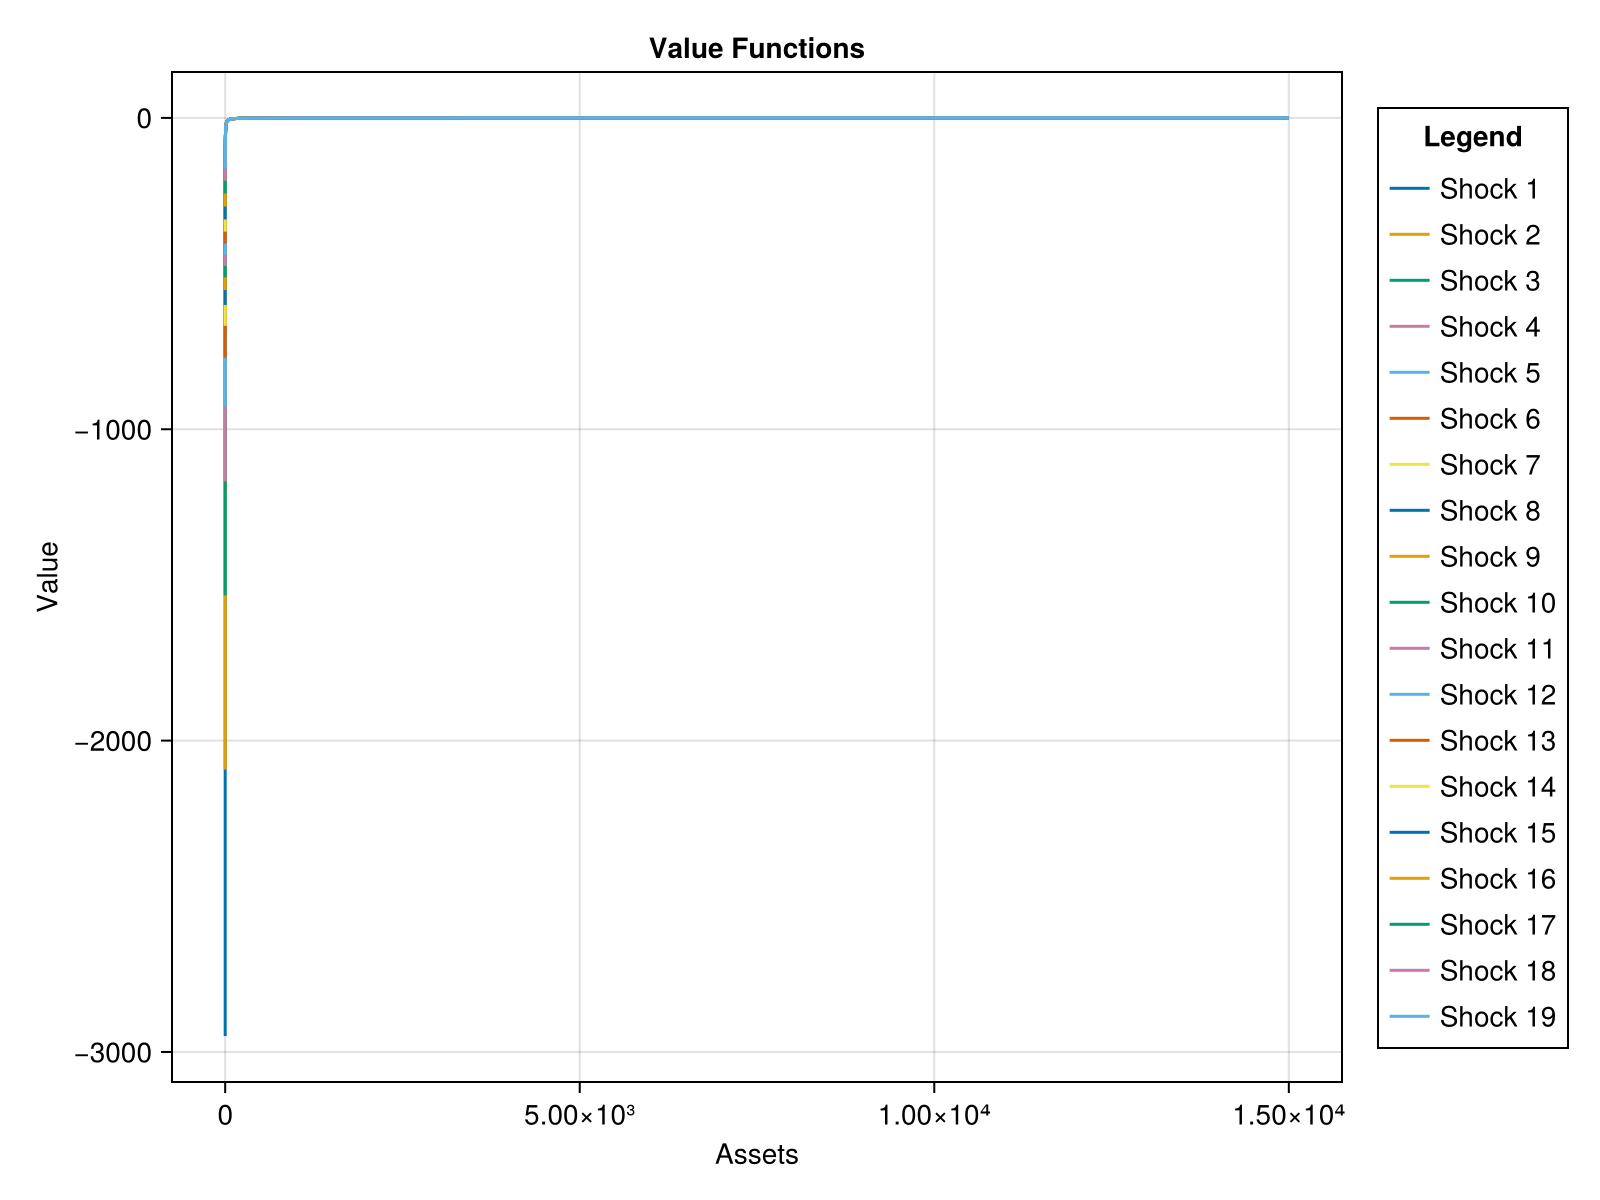

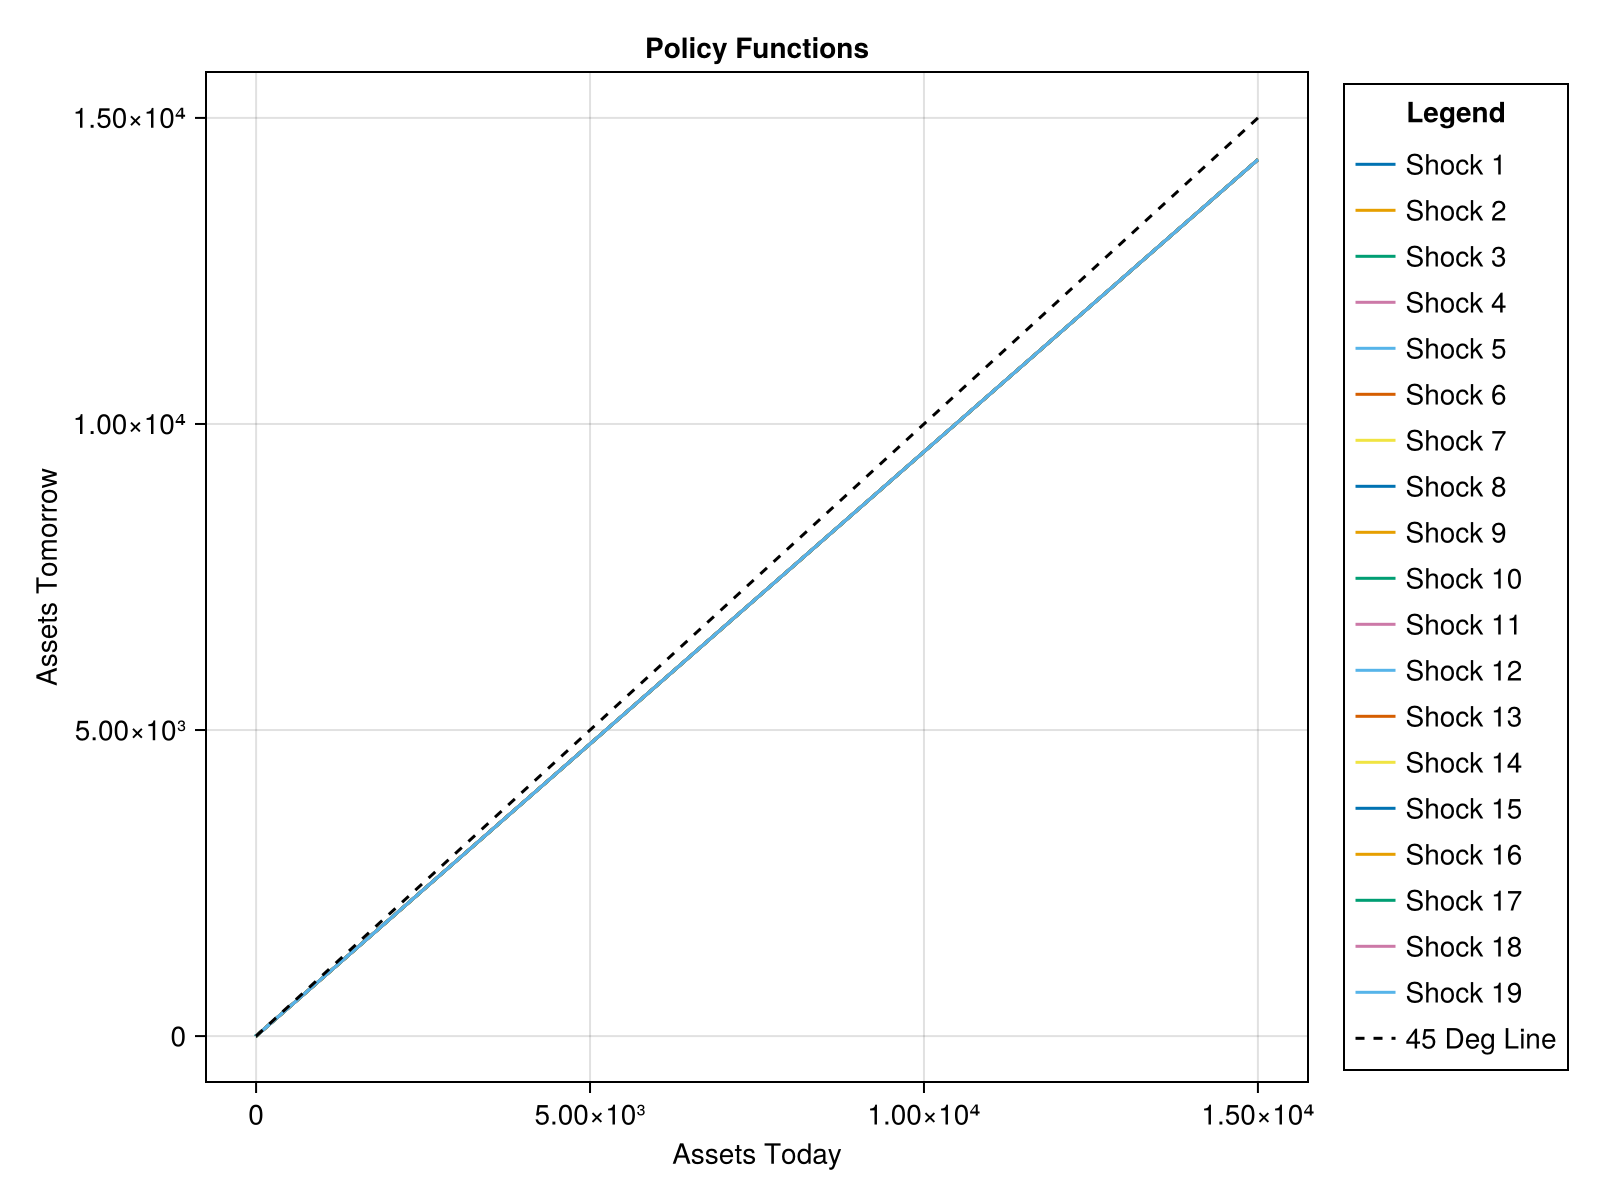

([-2949.0114048918035 -2093.2385673704466 … -202.02112941640493 -163.09948313164182; -2272.7858180197713 -1773.5893970489963 … -201.9947628347814 -163.0834423061873; … ; -0.020952138110431166 -0.02095213780384118 … -0.02095135188110768 -0.02095093610355595; -0.02012664413991535 -0.020126643857020902 … -0.020125918675204246 -0.020125535030683837], [4.006829973783575e-16 3.7934186959943416e-16 … 0.4720677245134853 0.7402350669041333; 3.3007872762538196e-16 2.515863501322938e-16 … 0.4722072971187096 0.7403759138649106; … ; 13754.544578061772 13754.544779281927 … 13755.060843717332 13755.333873563368; 14318.7457734288 14318.745974721027 … 14319.261942731791 14319.534921362714])

In [6]:
function vfi(v_init, pars)
    (; maxiter, toler, nz, na, print_skip) = pars
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:pars.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:pars.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

v_init = ones(pars.na, pars.nz)
pol_init = ones(pars.na, pars.nz)

@time begin
v_out, pol_out = vfi(v_init, pars)
end

Iterating...
--------------------
Iteration: 0, Error: 3.531368988256998e-6
--------------------
Converged in 2 iterations
--------------------
  1.225741 seconds (2.94 M allocations: 177.862 MiB, 2.91% gc time, 36.15% compilation time)


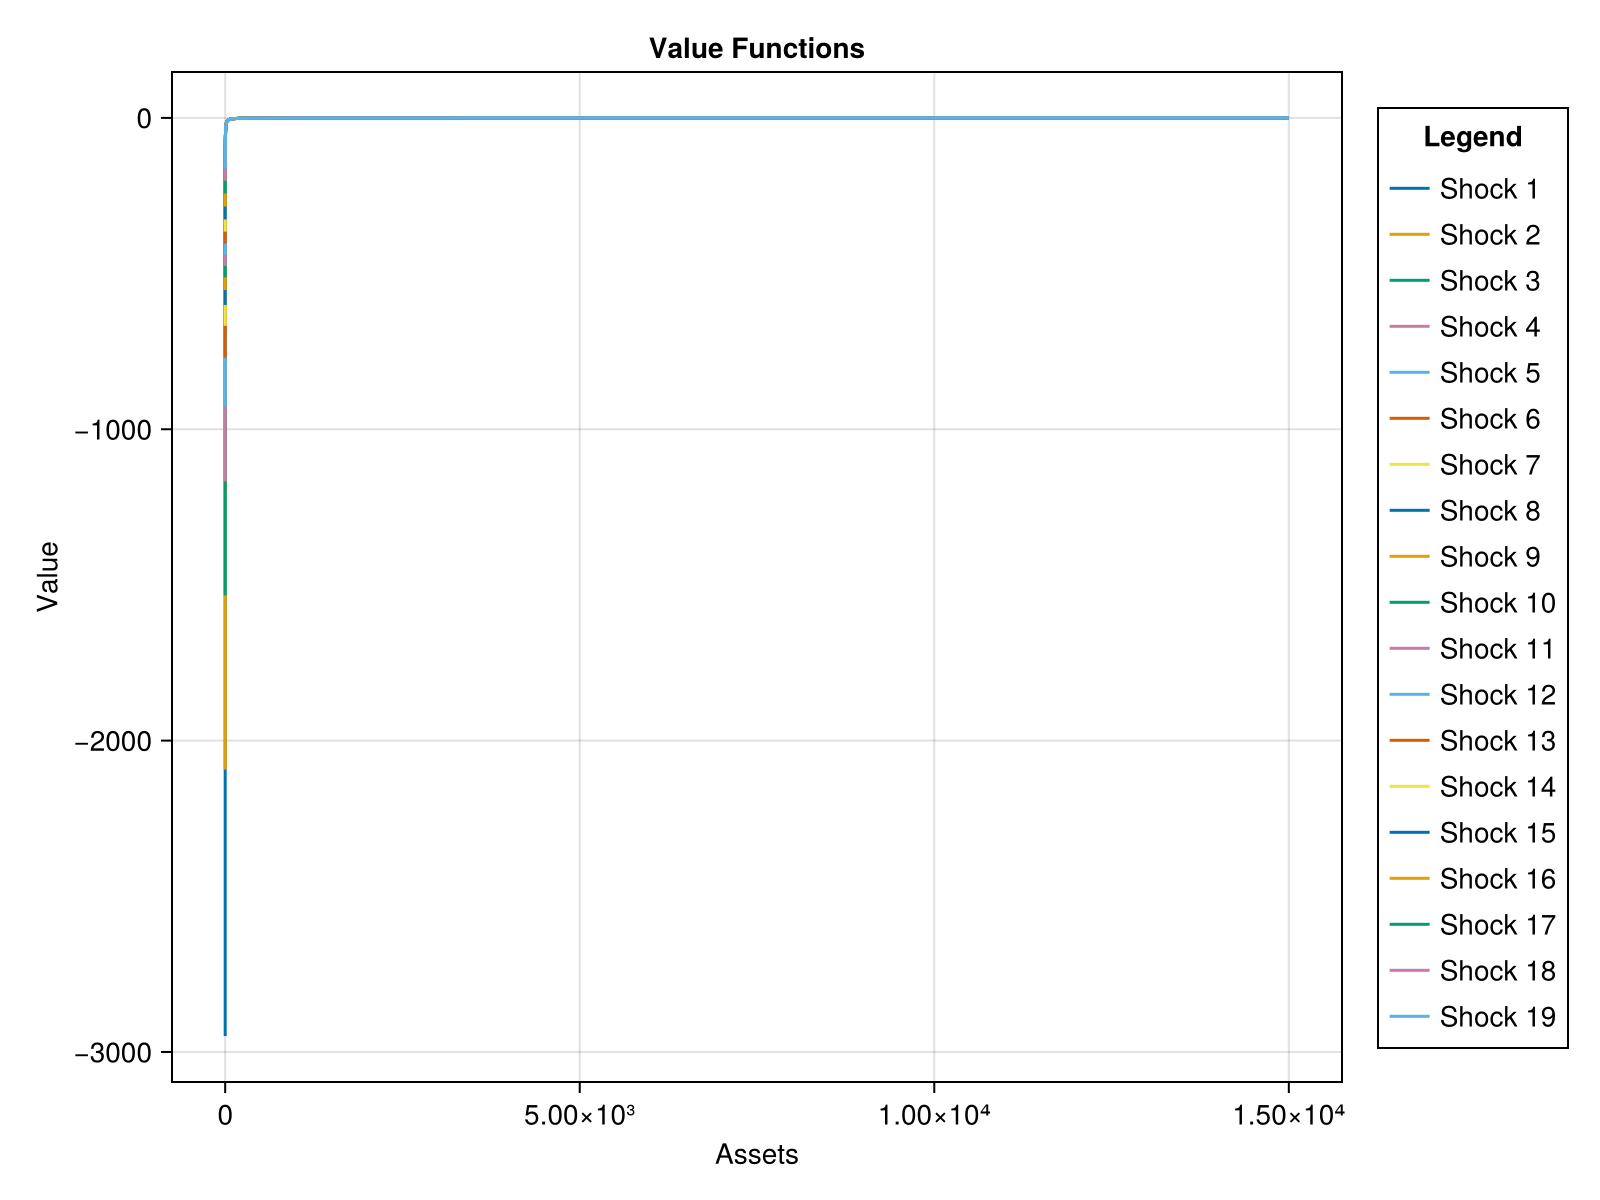

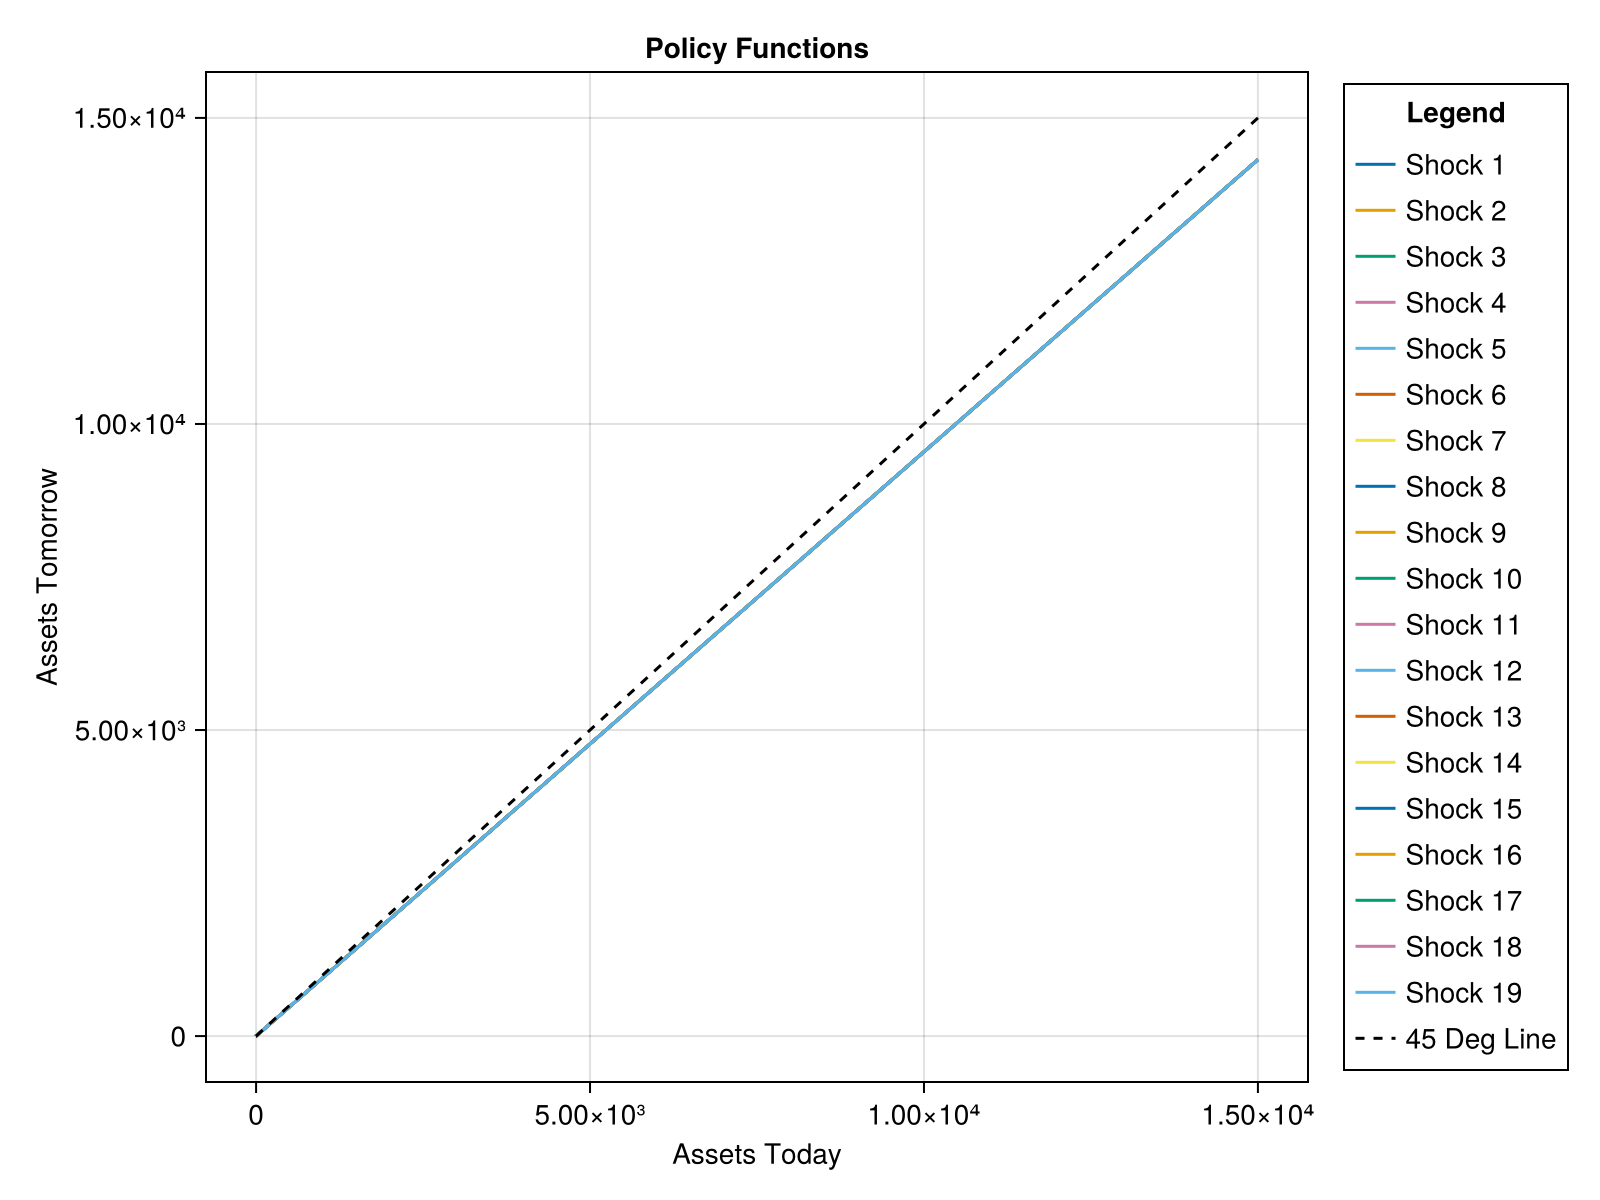

([-2949.011409259058 -2093.2385717377015 … -202.02113378365922 -163.09948749889654; -2272.7858223870257 -1773.589401416251 … -201.99476720203575 -163.08344667344198; … ; -0.020953338189256085 -0.020953337882651177 … -0.020952551921661004 -0.020952136123866344; -0.020127803808238712 -0.020127803525330334 … -0.02012707830782636 -0.020126694644422276], [4.0068299737835616e-16 3.7934186959943366e-16 … 0.4720677245100665 0.7402350669026577; 3.3007872762538157e-16 2.515863501322938e-16 … 0.4722072971122247 0.740375913864561; … ; 13754.564891726013 13754.565093057632 … 13755.08115849435 13755.354188852529; 14318.76715327716 14318.767354572263 … 14319.283323519454 14319.556302803596])

In [7]:
function hpi(v_init, policy, pars)
    (; maxiter, toler, print_skip) = pars
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
        v_new = howard(v_new, policy, Π, Avals, Zvals, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:pars.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:pars.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end
        
@time begin
    hpi_v, hpi_pol = hpi(v_init, pol_init, pars)
end    

In [6]:
p = (;r = 0.1111111111, # interest rate
    w = 0.00118, # wage   
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion (recall that this must be greater than 1 in the CES formulation)
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 501, # number of asset grid points
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    maxiter = 1000, # maximum no. of iterations
    how_iter = 50, # number of Howard iterations
    print_skip = 100, # how often to print
    lb = 0.0, # lower bound of capital grid
    ub = 100000000.0) # upper bound of capital grid

(r = 0.1111111111, w = 0.00118, β = 0.9, γ = 2.0, nz = 19, ρ = 0.9, μ = 0.0, σ = 0.003, na = 501, θ = 4.0, toler = 4.0e-7, maxiter = 1000, how_iter = 50, print_skip = 100, lb = 0.0, ub = 1.0e8)

In [7]:
function utility_CES(c, p)
    (; γ) = p
    return c^(1-γ)
end

function interpV_CES(Avals, v_slice, p)
    (; γ) = p
    interp_v = Spline1D(Avals, v_slice, k=1, bc="extrapolate")
    transformed_interp(x) = interp_v(x)^(1.0-p.γ)
    return transformed_interp
end

function optimise_CES(Avals, Zvals, v_init, v_new, policy, Π, p)
    (; β, na, nz, lb, γ) = p
    for i in 1:nz
        expected_value = v_init * Π[i,:]
        interpolation = interpV_CES(Avals, expected_value, p)
        for j in 1:na
            obj_CES(ap) = - (((1-β) * utility_CES(resources(Avals, Zvals, j, i, p) - ap, p) + β * interpolation(ap))^(1/(1-γ)))
            ub = resources(Avals, Zvals, j, i, p)  
            res = optimize(obj_CES, lb, ub)
            policy[j,i] = res.minimizer
            v_new[j,i] = -res.minimum
        end
    end
    return v_new, policy
end

function howard_CES(v, policy, Π, Agrid, Zgrid, p)
    (; β, na, nz, how_iter, γ) = p
    for _ in 1:how_iter
        for j in 1:nz
            exp_val = v * Π[j,:]
            interp_e_val = interpV_CES(Agrid, exp_val, p)
            for i in 1:na
                obj_CES(ap) = (((1-β) * utility_CES(resources(Agrid, Zgrid, i, j, p) - ap, p) + β * interp_e_val(ap)))^(1/(1-γ))
                v[i,j] = obj_CES(policy[i,j])
            end
        end
    end
    return v
end  

howard_CES (generic function with 1 method)

Iterating...
--------------------
Iteration: 0, Error: 0.9994803624262547
--------------------
Iteration: 100, Error: 0.09965992609129394
--------------------
Iteration: 200, Error: 0.0007777675402255802
--------------------
Converged in 273 iterations
--------------------
 17.922403 seconds (6.89 M allocations: 903.440 MiB, 0.57% gc time, 3.33% compilation time)


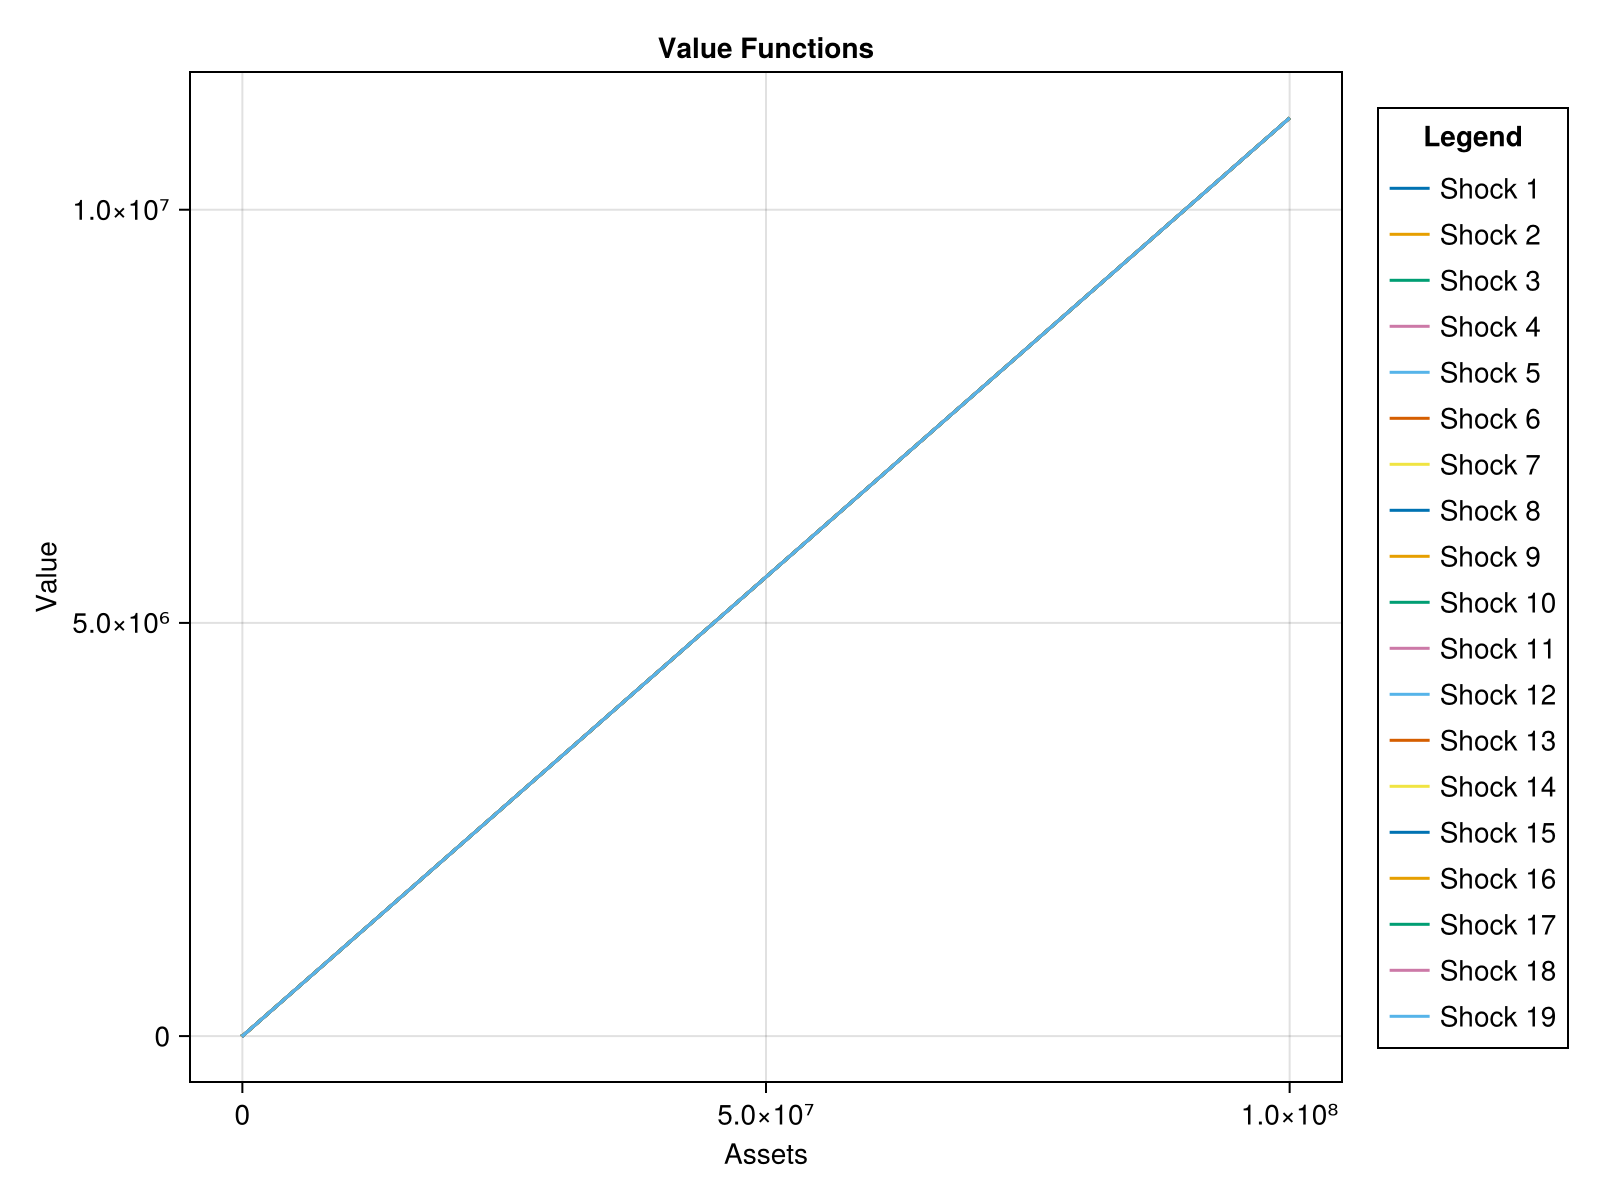

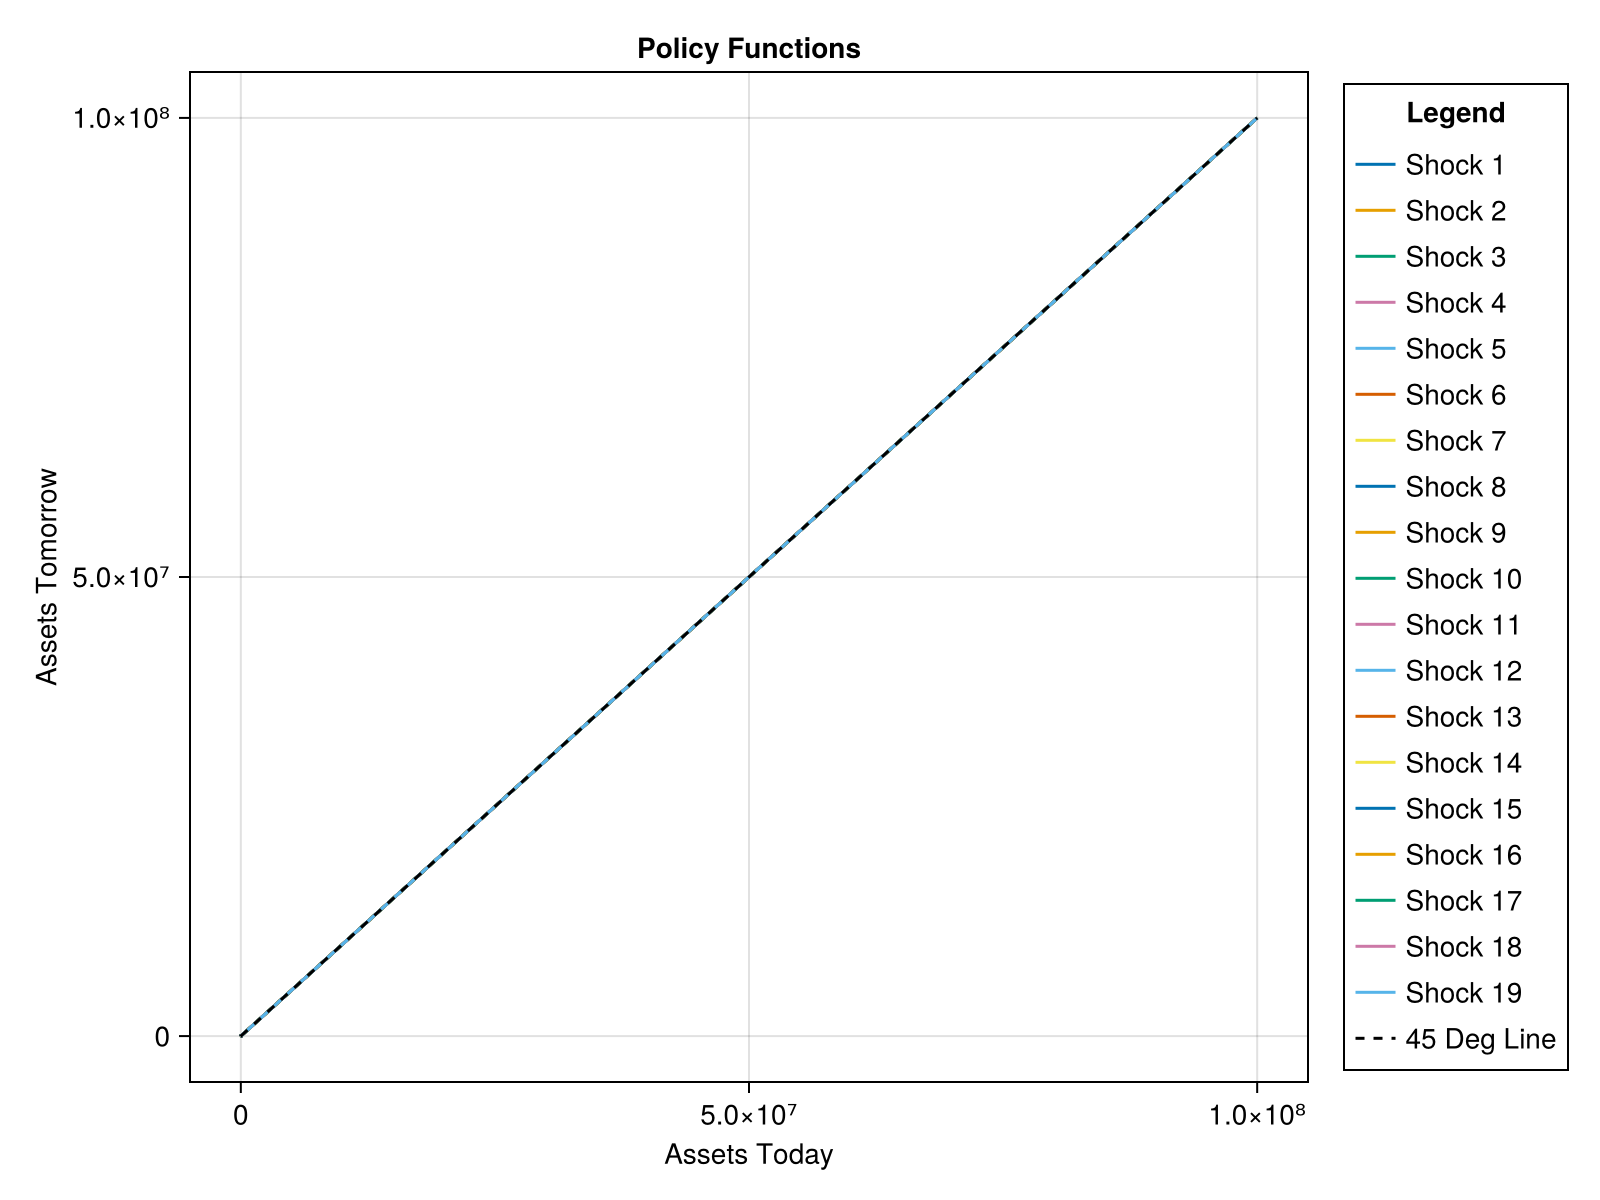

([0.00022380138919292464 0.00031865670081775713 … 0.005093503636050312 0.006960557179768911; 0.0015194139966977554 0.001521665612556899 … 0.00527165479126206 0.007138708334980656; … ; 1.1022449381208898e7 1.102244938121027e7 … 1.1022449384731846e7 1.102244938659497e7; 1.1111071328396041e7 1.1111071328397414e7 … 1.1111071331918988e7 1.1111071333782114e7], [3.4879662912265526e-16 3.171968105114183e-16 … 0.03016752893176632 0.046933837657488785; 0.0006169667114757591 0.0006289452856524041 … 0.031767342009893014 0.04853365104371679; … ; 9.920239676166852e7 9.920239676167555e7 … 9.920239679198253e7 9.920239680735588e7; 1.0000000026900822e8 1.0000000027041203e8 … 1.0000000029931922e8 1.0000000031748644e8])

In [8]:
function vfi_CES(v_init, p)
    (; maxiter, toler, nz, na, print_skip) = p
    Π, Zvals = ar1(p)
    Avals = exp_grid(p)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise_CES(Avals, Zvals, v_init, v_new, policy, Π, p)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:p.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:p.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

v2 = ones(p.na, p.nz)

@time begin
v_ces, pol_ces = vfi_CES(v2, p)
end

Iterating...
--------------------
Iteration: 0, Error: 3.580180988973592e-6
--------------------
Converged in 2 iterations
--------------------
  1.720041 seconds (1.62 M allocations: 243.463 MiB, 1.98% gc time, 34.56% compilation time)


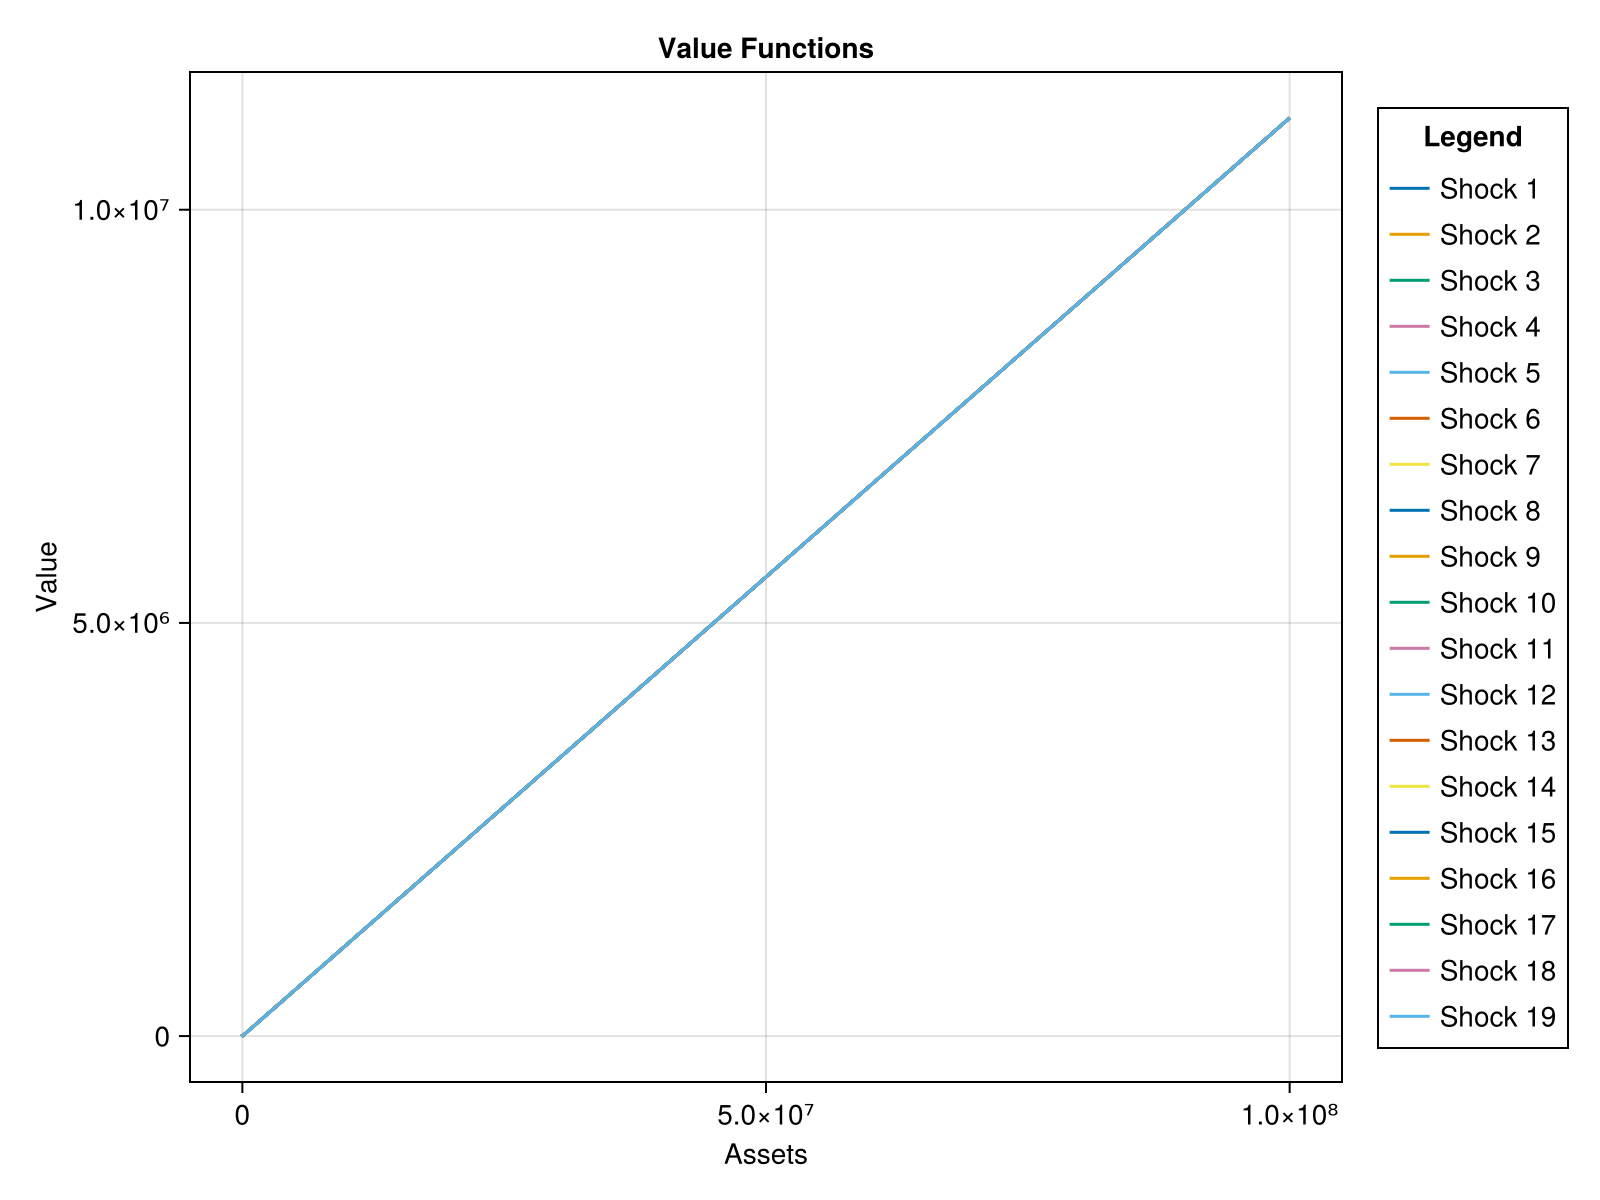

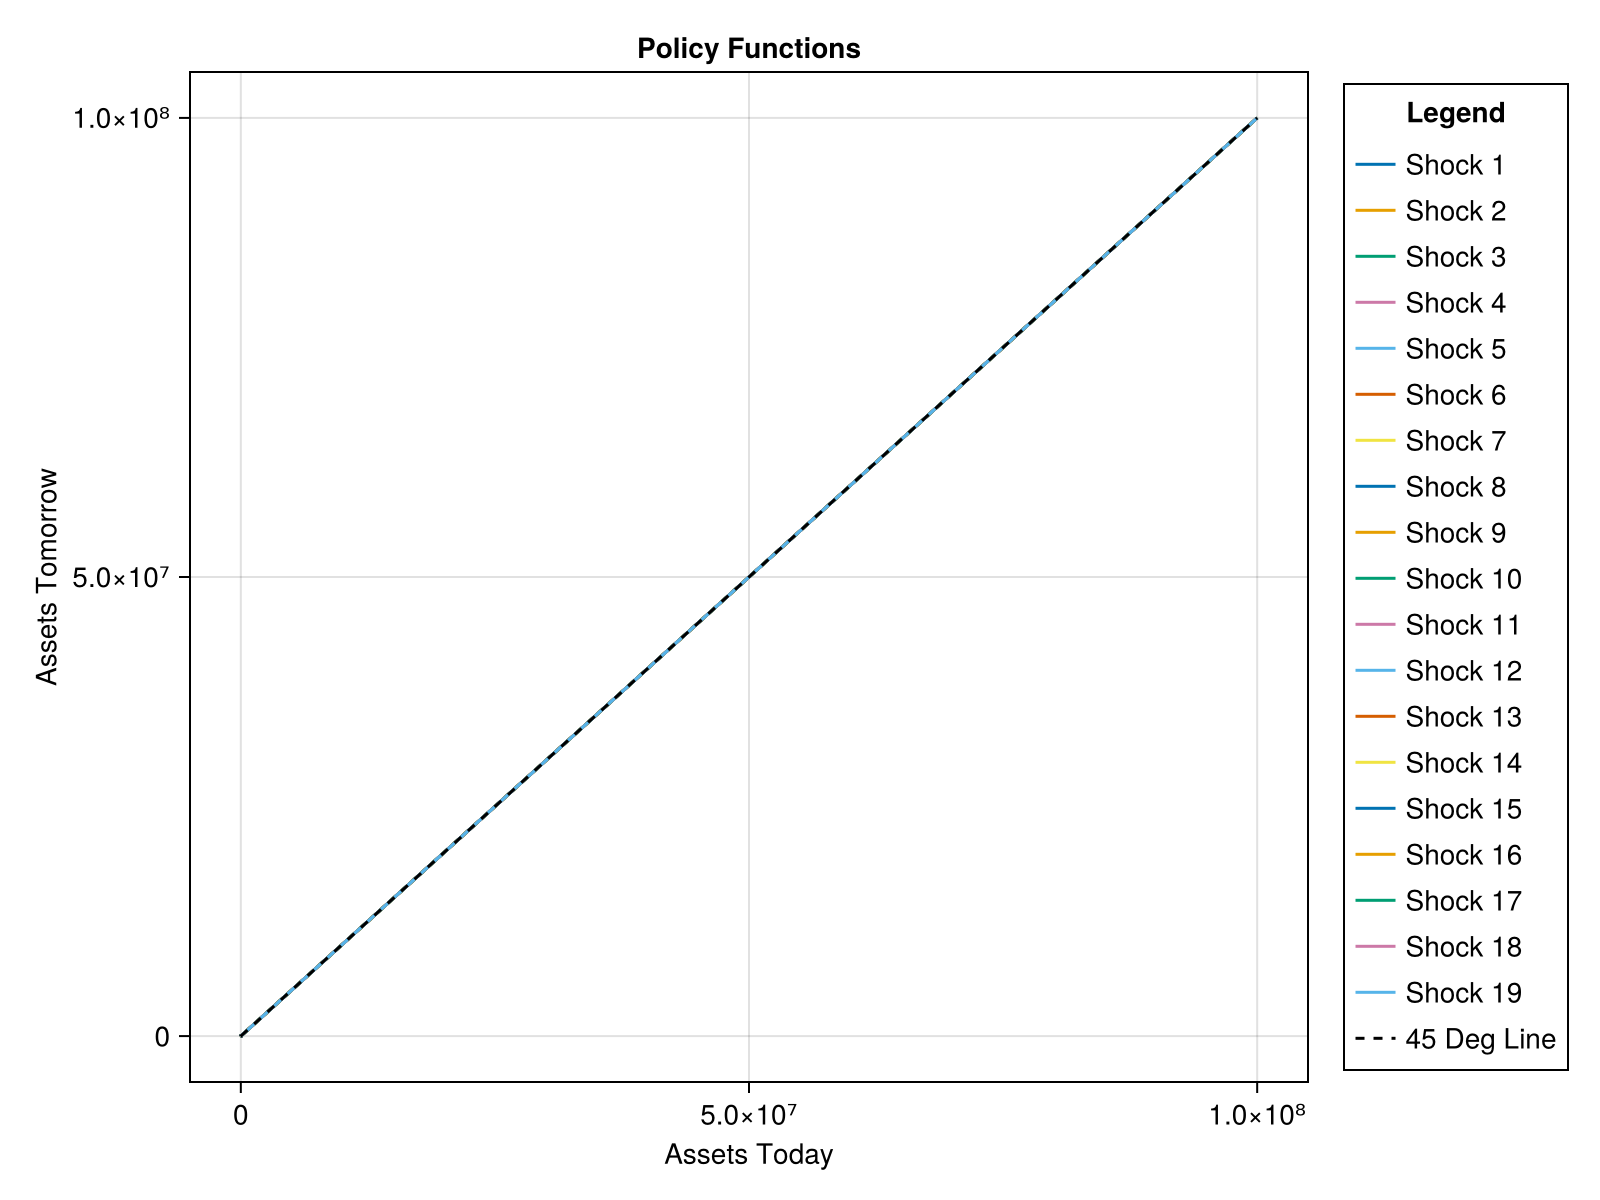

([0.0002238013891929149 0.0003186567008177374 … 0.005093503636047888 0.006960557179765375; 0.001519413996697316 0.0015216656125564586 … 0.005271654791259529 0.007138708334977017; … ; 1.1022488534003345e7 1.1022488534004716e7 … 1.102248853752638e7 1.102248853938952e7; 1.111111111159448e7 1.1111111111595854e7 … 1.1111111115117518e7 1.1111111116980659e7], [3.4879662912265526e-16 3.171968105114183e-16 … 0.0301675284822346 0.046933837657542825; 0.0006169667129474074 0.0006289452762155925 … 0.031767342009782706 0.04853365104359351; … ; 9.9202396805148e7 9.920239680516078e7 … 9.920239683823796e7 9.920239685081942e7; 1.0000000000483672e8 1.000000000034568e8 … 1.0000000003515226e8 1.0000000005191843e8])

In [9]:
function hpi_CES(v_init, p)
    (; maxiter, toler, nz, na, print_skip) = p
    Π, Zvals = ar1(p)
    Avals = exp_grid(p)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise_CES(Avals, Zvals, v_init, v_new, policy, Π, p)
        v_new = howard_CES(v_new, policy, Π, Avals, Zvals, p)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:p.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:p.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

@time begin
    hpi_v_CES, hpi_pol_CES = hpi_CES(v2, p)
end    